In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import LeakyReLU
from tensorflow.keras import layers
from tensorflow.keras import activations

def build(string):
    network = keras.models.Sequential()
    network.add(Dense(182, activation = string, input_shape=(x_train.shape[1],), kernel_regularizer=l2(1.e-4)))
    network.add(Dense(24, activation = string, kernel_regularizer=l2(1.e-2)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam" ,metrics=['accuracy'])
    return network

def data_prep(data):
    data.drop(columns=['yards_gained'], inplace=True)
    y = data['play_type']
    x = data.drop(columns = ['play_type'])
    x = pd.get_dummies(x)
    y = y.apply(playtypetobinary)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'score_differential']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
    return x_train, x_test, y_train, y_test

def cross_val(k, num_epochs, x_train, y_train, x_test, y_test, string):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build(string)
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Accuracy of the network is ', mae)
    with open(string + '.txt', 'w') as outfile:
        for x in range(len(val_history)):
            print(x, ' ', val_history[x], ' ', train_history[x], file=outfile)


def playtypetobinary(x):
    if x=='run':
        x = 0
    else:
        x = 1
    return x

In [7]:
df = pd.read_csv('data/Dane Panthers/NFLData.csv', index_col = 'game_date', parse_dates=True)

C:\Users\filip\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
data = df.loc['2018-01-01':]
todrop = np.loadtxt('data/regression_cols_out.txt', dtype='str')
data = data.reset_index()
data = data.rename(columns = {'index' : 'game_date'})
data = data.drop(columns = todrop)
data = data[data['play_type'].isin(['pass','run','qb_kneel','qb_spike'])]
data = data.replace('qb_spike', 'pass')
data = data.replace('qb_kneel', 'run')
data['qtr'] = data['qtr'].replace(1, 'first')
data['qtr'] = data['qtr'].replace(2, 'second')
data['qtr'] = data['qtr'].replace(3, 'third')
data['qtr'] = data['qtr'].replace(4, 'fourth')
data['down'] = data['down'].replace(1, 'first')
data['down'] = data['down'].replace(2, 'second')
data['down'] = data['down'].replace(3, 'third')
data['down'] = data['down'].replace(4, 'fourth')
data['posteam_timeouts_remaining'] = data['posteam_timeouts_remaining'].replace(1, 'one')
data['posteam_timeouts_remaining'] = data['posteam_timeouts_remaining'].replace(2, 'two')
data['posteam_timeouts_remaining'] = data['posteam_timeouts_remaining'].replace(3, 'three')
data['posteam_timeouts_remaining'] = data['posteam_timeouts_remaining'].replace(0, 'zero')
data['defteam_timeouts_remaining'] = data['defteam_timeouts_remaining'].replace(1, 'one')
data['defteam_timeouts_remaining'] = data['defteam_timeouts_remaining'].replace(2, 'two')
data['defteam_timeouts_remaining'] = data['defteam_timeouts_remaining'].replace(3, 'three')
data['defteam_timeouts_remaining'] = data['defteam_timeouts_remaining'].replace(0, 'zero')
print(data['play_type'].unique())

data = data.dropna()
data.isnull().sum()

['pass' 'run']


posteam                       0
defteam                       0
yardline_100                  0
quarter_seconds_remaining     0
qtr                           0
down                          0
ydstogo                       0
play_type                     0
yards_gained                  0
shotgun                       0
no_huddle                     0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
score_differential            0
dtype: int64

In [24]:
data.to_csv("OneSeasonNFL.csv", index=False)
data

,posteam,defteam,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,play_type,yards_gained,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential
2,ATL,PHI,80.0,900.0,first,first,15,pass,10.0,0,0,three,three,0.0
3,ATL,PHI,70.0,862.0,first,second,5,run,11.0,0,0,three,three,0.0
4,ATL,PHI,59.0,826.0,first,first,10,run,20.0,0,0,three,three,0.0
5,ATL,PHI,39.0,790.0,first,first,10,pass,0.0,0,0,three,three,0.0
6,ATL,PHI,39.0,785.0,first,second,10,pass,0.0,1,0,three,three,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42030,CAR,NO,66.0,64.0,fourth,first,10,pass,0.0,0,1,zero,one,-5.0
42031,CAR,NO,66.0,63.0,fourth,second,10,pass,0.0,1,0,zero,one,-5.0
42032,CAR,NO,66.0,58.0,fourth,third,10,pass,5.0,1,0,zero,one,-5.0
42033,CAR,NO,61.0,38.0,fourth,fourth,5,pass,0.0,1,1,zero,one,-5.0


In [4]:
#data = pd.read_csv("data/OneSeasonNFL.csv")
data = pd.read_csv('data/readyToGoNFL.csv')
x_train, x_test, y_train, y_test = data_prep(data)
benchmark = y_train.value_counts(normalize = True)

relu
Input size:  (258336, 93)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 182)               17108     
_________________________________________________________________
dense_82 (Dense)             (None, 24)                4392      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


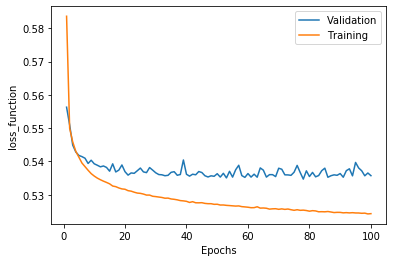

2019/2019 [==============================] - 2s 861us/step - loss: 0.5376 - accuracy: 0.7273
Accuracy of the network is  0.727336049079895
sigmoid
Input size:  (258336, 93)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 182)               17108     
_________________________________________________________________
dense_91 (Dense)             (None, 24)                4392      
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


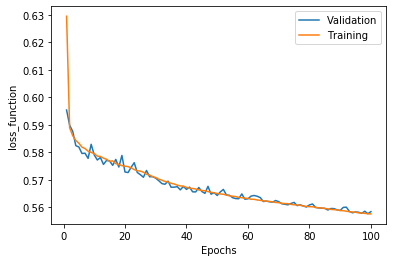

2019/2019 [==============================] - 2s 876us/step - loss: 0.5628 - accuracy: 0.7169
Accuracy of the network is  0.7168537378311157
softmax
Input size:  (258336, 93)
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 182)               17108     
_________________________________________________________________
dense_100 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


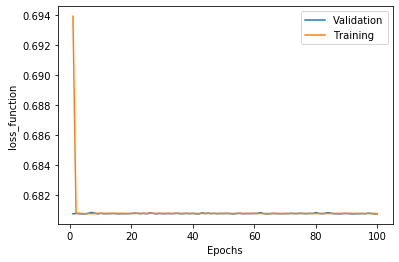

2019/2019 [==============================] - 2s 933us/step - loss: 0.6811 - accuracy: 0.5776
Accuracy of the network is  0.5775644779205322
softsign
Input size:  (258336, 93)
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_109 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


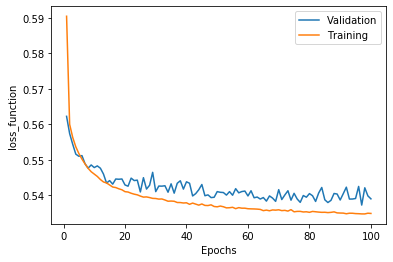

2019/2019 [==============================] - 2s 868us/step - loss: 0.5431 - accuracy: 0.7246
Accuracy of the network is  0.7246109843254089
softplus
Input size:  (258336, 93)
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_118 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


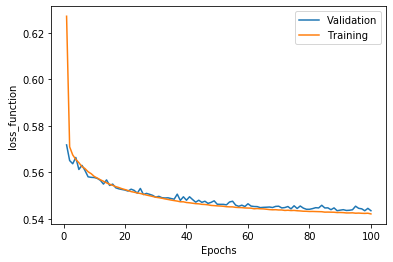

2019/2019 [==============================] - 2s 1ms/step - loss: 0.5460 - accuracy: 0.7223
Accuracy of the network is  0.7223349213600159
tanh
Input size:  (258336, 93)
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_127 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


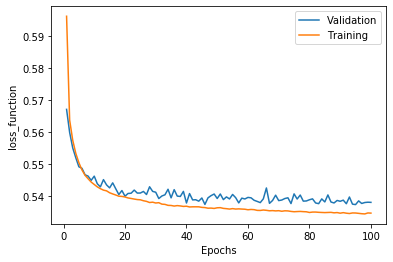

2019/2019 [==============================] - 3s 1ms/step - loss: 0.5415 - accuracy: 0.7240
Accuracy of the network is  0.7239761352539062
selu
Input size:  (258336, 93)
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_136 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


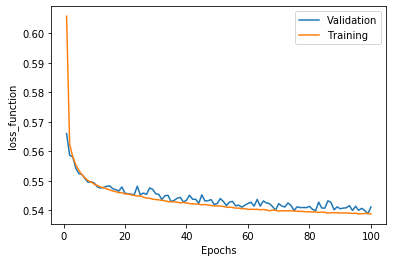

2019/2019 [==============================] - 2s 899us/step - loss: 0.5456 - accuracy: 0.7201
Accuracy of the network is  0.7201207876205444
elu
Input size:  (258336, 93)
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_145 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


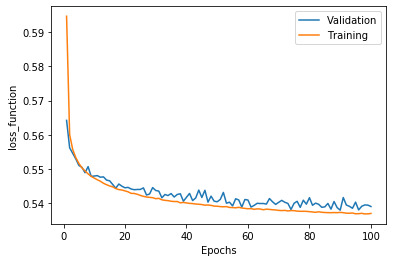

2019/2019 [==============================] - 3s 1ms/step - loss: 0.5431 - accuracy: 0.7247
Accuracy of the network is  0.7247039079666138


In [9]:
fun = ['relu', 'sigmoid', 'softmax', 'softsign', 'softplus', 'tanh', 'selu', 'elu']
for s in fun:
    print(s)
    cross_val(3, 100, x_train, y_train, x_test, y_test, s)

In [21]:
print(benchmark)

1    0.584621
0    0.415379
Name: play_type, dtype: float64


C:\Users\filip\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


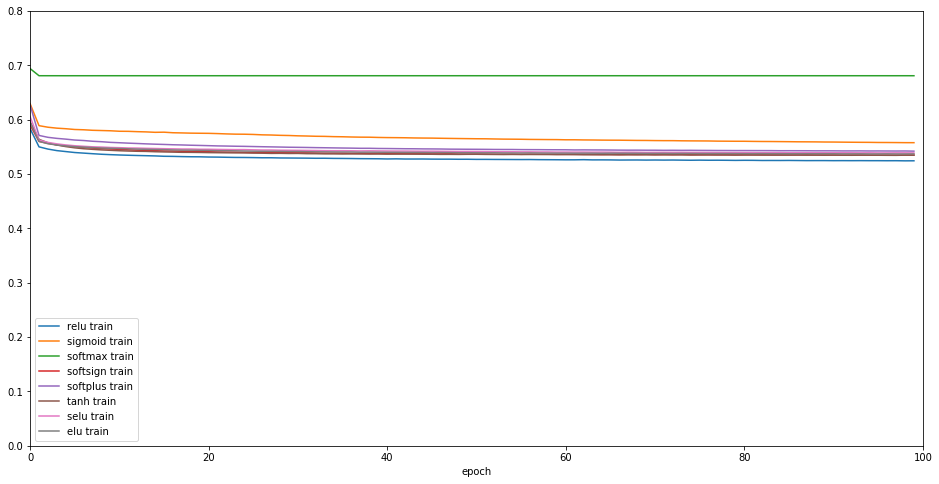

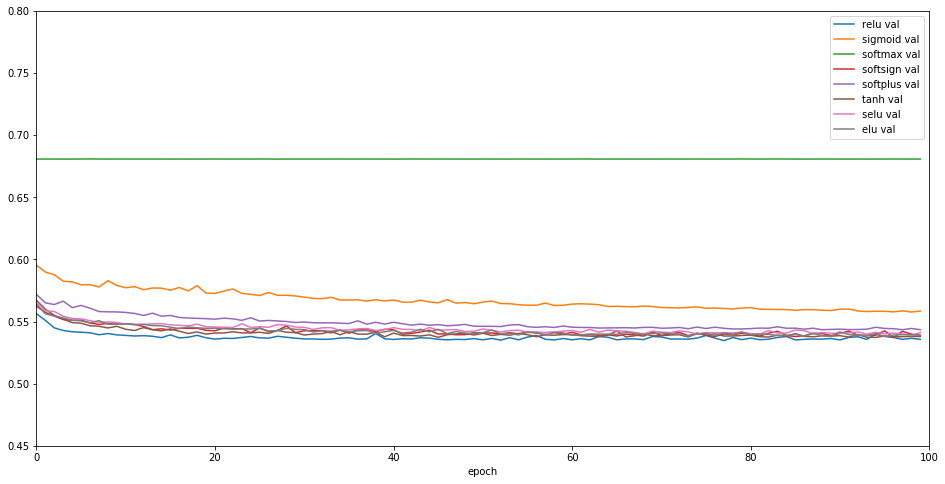

In [15]:
#plotting activation functions
fun = ['relu', 'sigmoid', 'softmax', 'softsign', 'softplus', 'tanh', 'selu', 'elu']
train = []
valid = []
for s in fun:
    df = pd.read_csv(s + '.txt', sep = '  ', header = None, names = ['epoch', s + ' val', s + ' train'], index_col = 'epoch')
    train.append(df.drop(columns = [s + ' val']))
    valid.append(df.drop(columns = [s + ' train']))

data = train[0].join(train[1:])
data2 = valid[0].join(valid[1:])

data.plot(xlim = (0, 100), ylim = (0 ,0.8), figsize = (16,8))
data2.plot(xlim = (0, 100), ylim = (0.45,0.8), figsize = (16,8))

    




In [20]:
def build(string):
    network = keras.models.Sequential()
    network.add(Dense(182, activation = 'tanh', input_shape=(x_train.shape[1],), kernel_regularizer=l2(1.e-4)))
    network.add(Dense(24, activation = 'relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam" ,metrics=['accuracy'])
    return network

Input size:  (258336, 93)
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_187 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


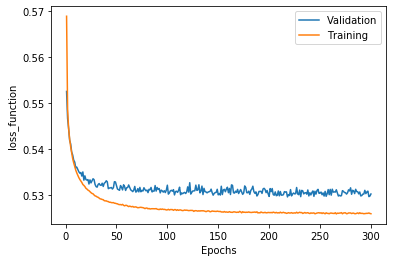

2019/2019 [==============================] - 2s 1ms/step - loss: 0.5365 - accuracy: 0.7298
Accuracy of the network is  0.7298288941383362


In [21]:
cross_val(4, 300, x_train, y_train, x_test, y_test, 'tanh-relu')

In [22]:
def build(string):
    network = keras.models.Sequential()
    network.add(Dense(182, activation = 'elu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(1.e-4)))
    network.add(Dense(24, activation = 'relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam" ,metrics=['accuracy'])
    return network

Input size:  (258336, 93)
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 182)               17108     
_________________________________________________________________
dense_199 (Dense)            (None, 24)                4392      
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 25        
Total params: 21,525
Trainable params: 21,525
Non-trainable params: 0
_________________________________________________________________
None


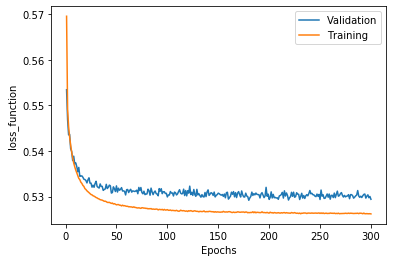

2019/2019 [==============================] - 2s 1ms/step - loss: 0.5327 - accuracy: 0.7299
Accuracy of the network is  0.7299063205718994


In [23]:
cross_val(4, 300, x_train, y_train, x_test, y_test, 'elu-relu')